In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 80000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (80000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

# EDA

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(71391, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.23875

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(71389, 10)


1    59779
0    11610
Name: Score, dtype: int64

# Preprocessing

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I love this stuff!  I routinely went through one package a week because it was so well made and seasoned.  All of my local stores stopped carrying this brand, and none of the others even come close to the goodness of Melissa's.  It is a perfect ingredient for potatoes, eggs, beans, Mexican pizza, tacos, chili stew, tons of things.<br /><br />I am glad I found it here so I no longer have to go through my Soyrizo withdrawals. (Unfortunately the online price is quite a bit more expensive than finding it locally, which was around $3.50 a package or so.)
I love Lady Finger popcorn.  It has so much flavor. It's a million times better than microwave popcorn and a thousand times

In [16]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I love this stuff!  I routinely went through one package a week because it was so well made and seasoned.  All of my local stores stopped carrying this brand, and none of the others even come close to the goodness of Melissa's.  It is a perfect ingredient for potatoes, eggs, beans, Mexican pizza, tacos, chili stew, tons of things.I am glad I found it here so I no longer have to go through my Soyrizo withdrawals. (Unfortunately the online price is quite a bit more expensive than finding it locally, which was around $3.50 a package or so.)
I love Lady Finger popcorn.  It has so much flavor. It's a million times better than microwave popcorn and a thousand times better than

In [18]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love Lady Finger popcorn.  It has so much flavor. It is a million times better than microwave popcorn and a thousand times better than the popcorn in the super-market.<br /><br />Warning....Once you have the good stuff, you will never want to eat regular popcorn again.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love Lady Finger popcorn It has so much flavor It is a million times better than microwave popcorn and a thousand times better than the popcorn in the super market br br Warning Once you have the good stuff you will never want to eat regular popcorn again 


In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 71389/71389 [00:42<00:00, 1683.72it/s]


In [24]:
preprocessed_reviews[1500]

'love lady finger popcorn much flavor million times better microwave popcorn thousand times better popcorn super market warning good stuff never want eat regular popcorn'

## Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [30]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('fantastic', 0.8191298246383667), ('awesome', 0.8170857429504395), ('excellent', 0.8124822378158569), ('good', 0.8073574900627136), ('terrific', 0.8011935949325562), ('perfect', 0.7685235142707825), ('wonderful', 0.7532691955566406), ('amazing', 0.7327579259872437), ('fabulous', 0.7012192010879517), ('nice', 0.6922681331634521)]
[('greatest', 0.784604549407959), ('tastiest', 0.7241618633270264), ('best', 0.7228500843048096), ('nastiest', 0.7022992372512817), ('closest', 0.659115731716156), ('coolest', 0.6561566591262817), ('awful', 0.6294412612915039), ('ive', 0.6059162616729736), ('horrible', 0.6042490601539612), ('softest', 0.5951994061470032)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15897
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'problem', 'lot', 'fruit', 'flies', 'kitchen', 'picked', 'care', 'business', 'despite', 'spotty', 'reviews', 'oops', 'several', 'days', 'fly', 'land', 'entire', 'time']


# Avg W2v

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 71389/71389 [04:26<00:00, 268.22it/s]


71389
50


In [33]:
final['Score'].value_counts()

1    59779
0    11610
Name: Score, dtype: int64

In [34]:
x=sent_vectors
y=final['Score']

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\Meraj\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
# split the data set into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [37]:
#split the data set into train and cross validation
x_traincv, x_cv, y_traincv, y_cv = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [38]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(x_traincv, y_traincv)

    # predict the response on the crossvalidation train
    pred_w2v = knn.predict(x_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred_w2v, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc)) 


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 86%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%

CV accuracy for k = 21 is 87%

CV accuracy for k = 23 is 87%

CV accuracy for k = 25 is 87%

CV accuracy for k = 27 is 87%

CV accuracy for k = 29 is 87%


In [39]:
knn = KNeighborsClassifier(5)
knn.fit(x_train, y_train)
pred_w2v = knn.predict(x_test)
acc = accuracy_score(y_test, pred_w2v, normalize=True) * float(100)
print('\nTest accuracy for k = 5 is %d%%' % (acc))


Test accuracy for k = 5 is 87%


In [59]:
knn_kd_tree = KNeighborsClassifier(n_neighbors=5, algorithm = 'kd_tree')

# fitting the model
knn_kd_tree.fit(x_train, y_train)

# predict the response
pred_w2v1 = knn_kd_tree.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred_w2v1) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (5, acc))


The accuracy of the knn classifier for k = 5 is 87.458561%


In [42]:
knn.predict(x_test)[0:10]

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [43]:
knn.predict_proba(x_test)[0:10,:]

array([[0.8, 0.2],
       [0. , 1. ],
       [0.6, 0.4],
       [0.8, 0.2],
       [0. , 1. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0.2, 0.8],
       [0. , 1. ],
       [0. , 1. ]])

In [44]:
y_pred_prob = knn.predict_proba(x_test)[:,1]

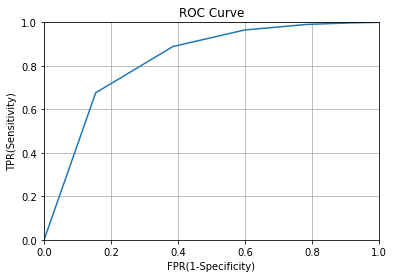

In [49]:
fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred_prob)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC Curve')
plt.xlabel('FPR(1-Specificity)')
plt.ylabel('TPR(Sensitivity)')
plt.grid(True)

In [53]:
metrics.roc_auc_score(y_test,y_pred_prob)

0.8271166605406978

In [75]:
y_test.shape

(21417,)

In [76]:
pred_w2v1.shape

(21417,)

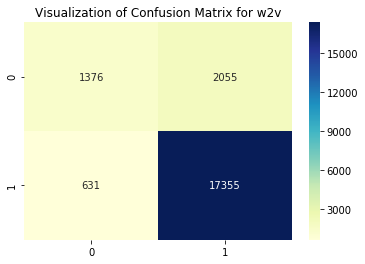

In [57]:
Matrix = confusion_matrix(y_test, pred_w2v1, labels=None, sample_weight=None)
ax = sns.heatmap(Matrix,annot=True,fmt="d",cmap="YlGnBu")
plt.title("Visualization of Confusion Matrix for w2v")
plt.show()

# TFIDF weighted W2v

In [60]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 71389/71389 [53:57<00:00, 22.05it/s]


In [62]:
x1=tfidf_sent_vectors
y1=final['Score']

In [79]:
# split the data set into train and test
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=0)
#split the data set into train and cross validation
x1_traincv, x1_cv, y1_traincv, y1_cv = train_test_split(x1_train, y1_train, test_size=0.3, random_state=0)

In [80]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(x1_traincv, y1_traincv)

    # predict the response on the crossvalidation train
    pred_tfidf_w2v = knn.predict(x1_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y1_cv, pred_tfidf_w2v, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc)) 


CV accuracy for k = 1 is 82%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 86%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 86%

CV accuracy for k = 13 is 86%

CV accuracy for k = 15 is 86%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 86%

CV accuracy for k = 21 is 86%

CV accuracy for k = 23 is 86%

CV accuracy for k = 25 is 86%

CV accuracy for k = 27 is 86%

CV accuracy for k = 29 is 86%


In [81]:
knn.predict(x1_test)[0:10]

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [66]:
knn.predict_proba(x1_test)[0:10,:]

array([[0.68965517, 0.31034483],
       [0.        , 1.        ],
       [0.55172414, 0.44827586],
       [0.37931034, 0.62068966],
       [0.06896552, 0.93103448],
       [0.17241379, 0.82758621],
       [0.72413793, 0.27586207],
       [0.20689655, 0.79310345],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [ ]:
knn.predict_proba(x1_test)[0:10,:]

In [67]:
y_pred_prob1 = knn.predict_proba(x_test1)[:,1]

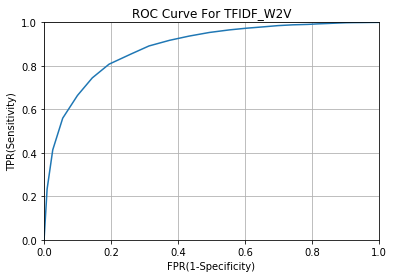

In [68]:
fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred_prob1)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC Curve For TFIDF_W2V')
plt.xlabel('FPR(1-Specificity)')
plt.ylabel('TPR(Sensitivity)')
plt.grid(True)

In [69]:
metrics.roc_auc_score(y_test,y_pred_prob1)

0.884852853427273

In [73]:
y_test1.shape

(21417,)

In [74]:
pred_tfidf_w2v.shape

(14992,)